This is a simulation of the rerouting algorithm. We will be using the PUJ route T307 (Boni - Pinatubo → Stop n' Shop).

In [1]:
!pip3 install -q osmnx contextily overpass overpy osmapi

  You can safely remove it manually.
  You can safely remove it manually.


In [28]:
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx
import pandas as pd
import osmnx as ox
import random
import json
import geopandas as gpd
import numpy as np
import random
import itertools

import overpass
from shapely.geometry import Polygon, LineString, Point
import overpy
from osmapi import OsmApi

## Prepare Data

### Creating Bounding Box

In [3]:
BOUNDING_BOX = (14.60692, 14.56838, 121.06303, 120.99891) # bounding box as (north, south, east, west)
graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)

/tmp/ipykernel_180/3675650549.py:2: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)


### Plot Area

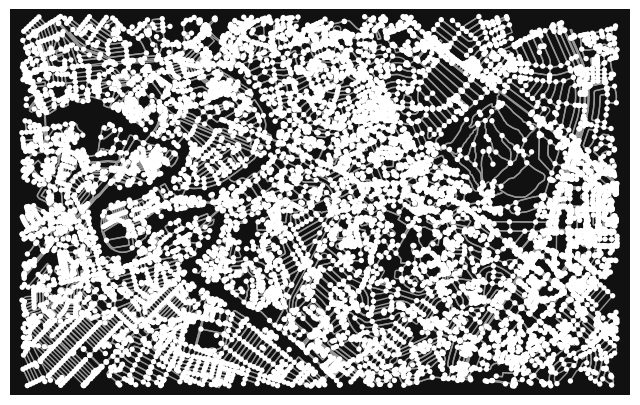

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(graph_of_area)

In [5]:
gdf_edges = ox.graph_to_gdfs(graph_of_area, nodes=False)

In [6]:
gdf_edges.head()

osmid  oneway lanes  ref  \
u        v          key                                                        
12067613 1981388318 0                           264965502    True     4    1   
         962953430  0    [29256184, 188165094, 188165111]    True     2    1   
12067619 6970838871 0                          1254512972    True   NaN  NaN   
         8459730704 0                           671955931    True     2    1   
12067627 8242414108 0                            22598208   False     2  NaN   

                                          name   highway maxspeed reversed  \
u        v          key                                                      
12067613 1981388318 0                     EDSA     trunk       60    False   
         962953430  0                     EDSA     trunk       60    False   
12067619 6970838871 0    Starmall Service Road   service      NaN    False   
         8459730704 0                     EDSA     trunk       60    False   
12067627 8242414108 0               Apo Street  tertiary      NaN    False   

                          length tunnel  \
u        v          key                   
12067613 1981388318 0     15.937    NaN   
         962953430  0    860.735    yes   
12067619 6970838871 0      5.014    NaN   
         8459730704 0    199.554    NaN   
12067627 8242414108 0      6.785    NaN   

                                                                  geometry  \
u        v          key                                                      
12067613 1981388318 0    LINESTRING (121.05548 14.58452, 121.05537 14.5...   
         962953430  0    LINESTRING (121.05548 14.58452, 121.05543 14.5...   
12067619 6970838871 0    LINESTRING (121.05468 14.58309, 121.05464 14.5...   
         8459730704 0    LINESTRING (121.05468 14.58309, 121.05400 14.5...   
12067627 8242414108 0    LINESTRING (121.04673 14.57158, 121.04667 14.5...   

                             access service width junction bridge  
u        v          key                                            
12067613 1981388318 0           NaN     NaN   NaN      NaN    NaN  
         962953430  0           NaN     NaN   NaN      NaN    NaN  
12067619 6970838871 0    permissive     NaN   NaN      NaN    NaN  
         8459730704 0           NaN     NaN   NaN      NaN    NaN  
12067627 8242414108 0           NaN     NaN   NaN      NaN    NaN

In [7]:
gdf_edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
gdf_edges_web_mercator = gdf_edges.to_crs(epsg=3857)

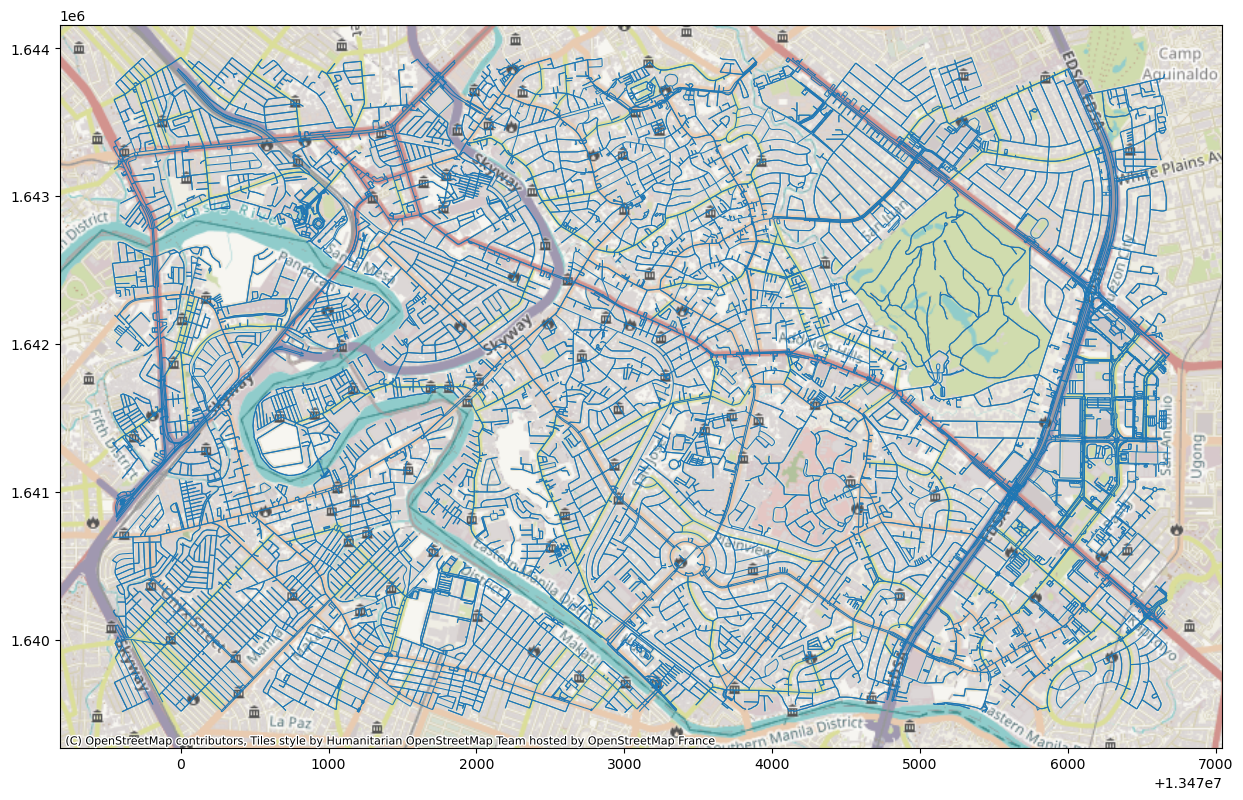

In [12]:
_, ax = plt.subplots(1,1, figsize=(15,15))
gdf_edges_web_mercator.plot(linewidth=.75, ax=ax)
cx.add_basemap(ax=ax, url=cx.providers.CartoDB.Positron)

### Using overpy

In [83]:
api = overpy.Overpass()
relation_id = 11246071

In [84]:
# Query to fetch the relation by ID
query = f"""
relation({relation_id});
out body;
"""

# Fetch the relation data
result = api.query(query)

# Check if we got the relation
if len(result.relations) > 0:
    relation = result.relations[0]  # Access the first relation
else:
    print("No relation found.")

In [85]:
node_ids = []
way_ids = []
for member in relation.members:
    if type(member) == overpy.RelationNode:
        node_ids.append(member.ref)
    elif type(member) == overpy.RelationWay:
        way_ids.append(member.ref)

In [86]:
query = f"""
node(id:{','.join(map(str, node_ids))});
out body;
"""
result = api.query(query)
    
def get_nodes():
    for node in result.get_nodes():
        yield Point(node.lon, node.lat)

In [87]:
query = f"""
way(id:{','.join(map(str, way_ids))});
out body;
"""
result = api.query(query)


In [88]:
for way in result.get_ways():
    way.get_nodes(resolve_missing=True)

In [89]:
def get_nodes():
    for way in result.get_ways():
        for node in way.get_nodes(resolve_missing=True):
            yield node

def get_ways():
    for way in result.get_ways():
        yield LineString(Point(node.lon, node.lat) for node in way.get_nodes(resolve_missing=True))

In [90]:
def get_nearest_nodes_from(graph, lst_of_ll) -> list:
    for node in lst_of_ll:
        x = np.float64(node.lon)
        y = np.float64(node.lat)
        nn, _ = tuple(nn_dist for nn_dist in ox.distance.nearest_nodes(graph, x, y, return_dist=True))
        yield nn

def generate_subgraph_from_node_lst(graph, node_lst) -> nx.Graph:
    SG = graph.__class__()
    SG.add_nodes_from((n, graph.nodes[n]) for n in node_lst)
    if SG.is_multigraph():
        SG.add_edges_from(
            (n, nbr, key, d)
            for n, nbrs in graph.adj.items()
            if n in node_lst
            for nbr, keydict in nbrs.items()
            if nbr in node_lst
            for key, d in keydict.items()
        )
    else:
        SG.add_edges_from(
            (n, nbr, d)
            for n, nbrs in graph.adj.items()
            if n in node_lst
            for nbr, d in nbrs.items()
            if nbr in node_lst
        )
    SG.graph.update(graph.graph)
    return SG

In [106]:
def plot_graph(graph):
    subgraph_edges = ox.graph_to_gdfs(graph, nodes=False)
    _, ax = plt.subplots(figsize=(12, 12))
    subgraph_edges = subgraph_edges.to_crs(epsg=3857)
    subgraph_edges.plot(ax=ax, edgecolor='blue')
    cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()

### Create Subgraph

In [91]:
subgraph = graph_of_area.subgraph(result.get_node_ids())

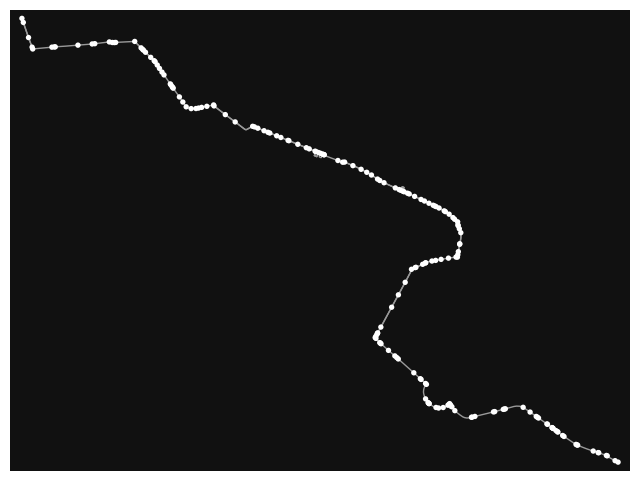

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [92]:
ox.plot_graph(subgraph)

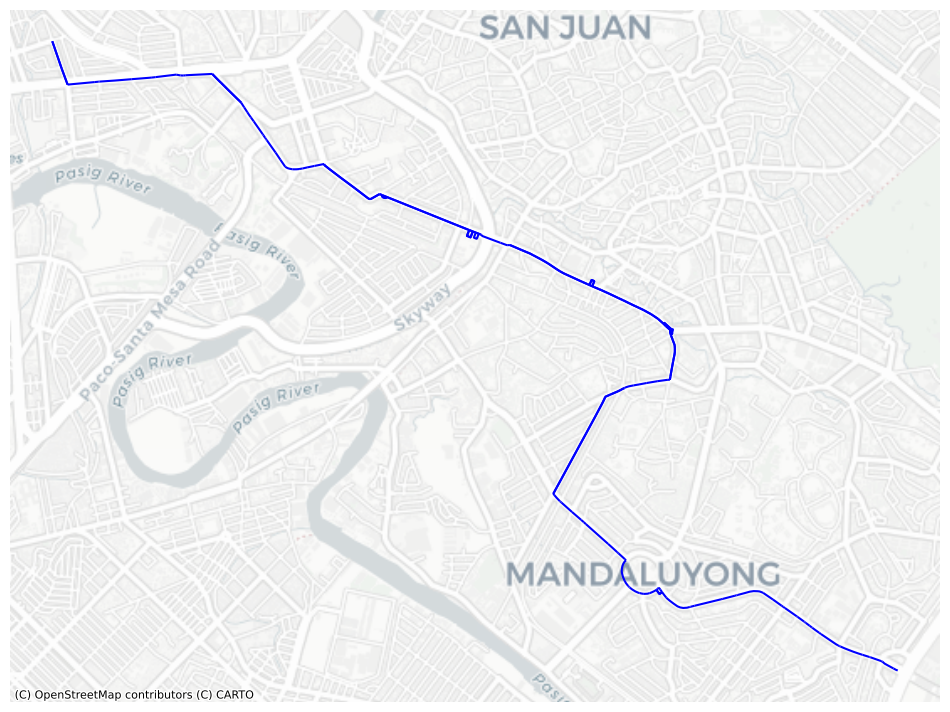

In [93]:
plot_graph(subgraph)

That looks good. However, relations in osmnx are not updated when nodes and edges are updated. Let's use a script to ensure that our route's nodes and edges exist in the osm api.

In [ ]:
node_lst = list(get_nearest_nodes_from(graph_of_area, get_nodes()))

subgraph = generate_subgraph_from_node_lst(graph_of_area, node_lst)
ox.plot_graph(subgraph)

# remove vertices with degree of 0
subgraph.remove_nodes_from(list(nx.isolates(subgraph)))

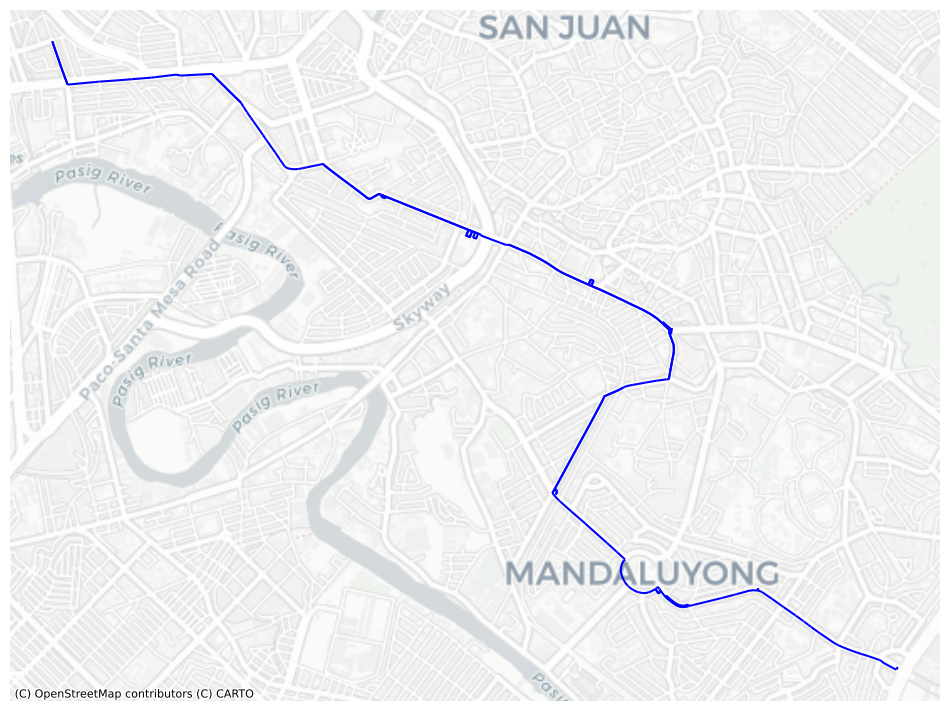

In [107]:
plot_graph(subgraph)

In [108]:
ox.io.save_graphml(subgraph, '../graphs/graphml/jeepneyroutes/T307-Subgraph.graphml')

### Simulate Random Flooding and Rerouting Procedures

In [112]:
def get_nearest_node_and_delete_it(node_id, graph, x, y):
    graph.remove_node(node_id)
    return get_nearest_node(graph, x, y)

def get_nearest_node(graph, x, y):
    nn, _ = tuple(nn_dist for nn_dist in ox.distance.nearest_nodes(graph.copy(), x, y, return_dist=True))
    return nn

def get_random_lst_of_nodes(graph, num_nodes_to_delete):
    random_nodes = []
    counter = 0
    while True:
        if counter == 5:
            break
        node = random.choice(list(graph.nodes))
        if len(list(graph.neighbors(node))) < 2:
            continue
        else:
            random_nodes.append(node)
            counter += 1
    return random_nodes

In [114]:
G = graph_of_area.copy()
G_sub = subgraph.copy()
num_nodes_to_delete = 5
deleted_nodes = get_random_lst_of_nodes(G_sub, num_nodes_to_delete)
print(deleted_nodes)

shortest_paths_between_closest_nodes = []
for node_id in deleted_nodes:
    neighbors = list(G_sub.neighbors(node_id))
    G.remove_node(node_id)
    G_sub.remove_node(node_id)
    shortest_paths_between_closest_nodes.append(nx.shortest_path(G, source=neighbors[0], target=neighbors[1]))

[243193964, 6517417321, 6517417308, 261741416, 11658786368]


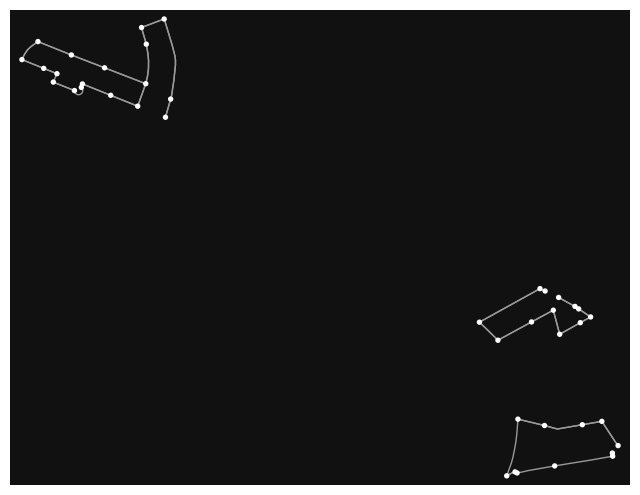

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [115]:
rerouted_sub_graph_lst = []
for path in shortest_paths_between_closest_nodes:
    rerouted_sub_graph_lst.append(graph_of_area.subgraph(path))
ox.plot_graph(nx.compose_all(rerouted_sub_graph_lst))

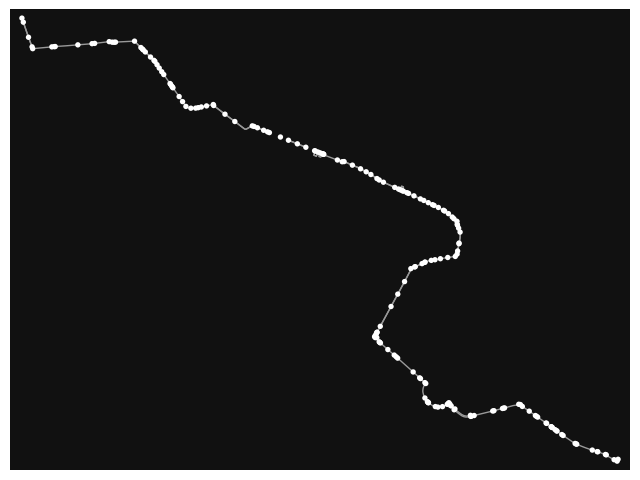

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [116]:
ox.plot_graph(G_sub)

In [117]:
rerouted_sub_graph = nx.compose(G_sub, nx.compose_all(rerouted_sub_graph_lst))
directed_rerouted_sub_graph = nx.MultiGraph(rerouted_sub_graph)

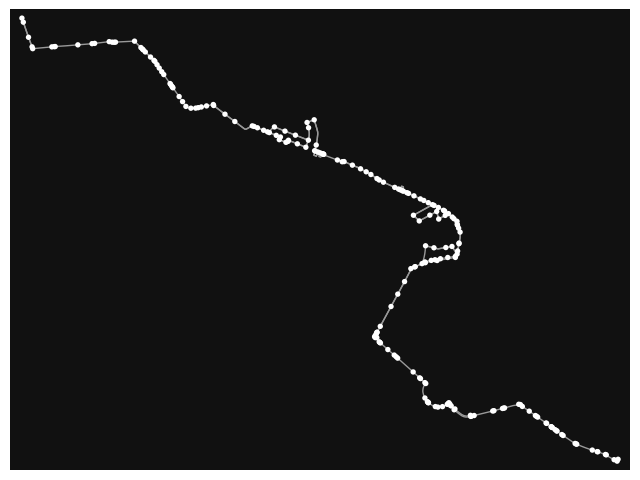

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [118]:
ox.plot_graph(rerouted_sub_graph)

# Conclusion

Written below was the discovery process that produced the desired effect above. These are not production codes.

In [37]:
pos = {node: (data['x'], data['y']) for node, data in directed_rerouted_sub_graph.nodes(data=True)}

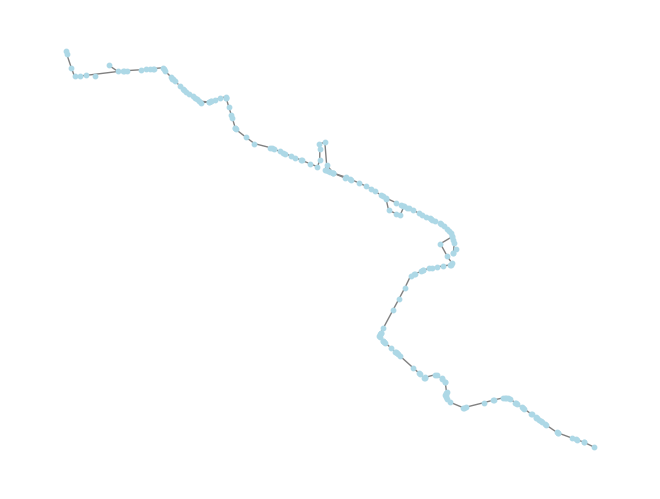

In [43]:
nx.draw(directed_rerouted_sub_graph, pos, with_labels=False, node_color="lightblue", edge_color="gray", node_size=10, font_size=10)

In [60]:
from itertools import chain

In [70]:
def flatten_lst(lst):
    return list(chain.from_iterable(lst))

In [71]:
node_list = flatten_lst(nx.biconnected_components(directed_rerouted_sub_graph))

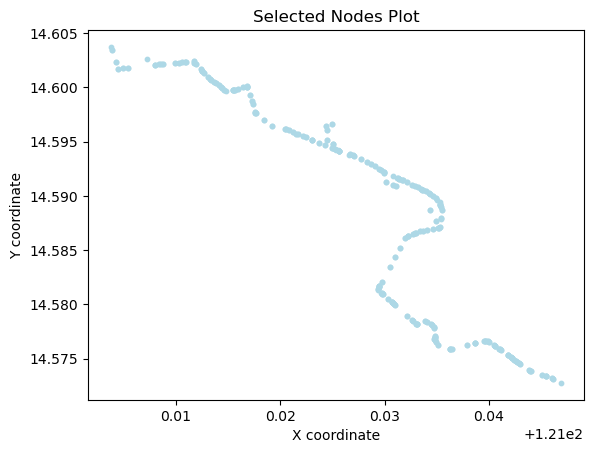

In [72]:
pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in node_list}

x_values = [pos[node][0] for node in node_list]
y_values = [pos[node][1] for node in node_list]

plt.scatter(x_values, y_values, c="lightblue", s=10)

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Selected Nodes Plot")
plt.show()

In [333]:
lst_of_subgraphs = []
for path in shortest_paths_between_closest_nodes:
    if len(path) > 2:
        edge_pairs = [tuple(edge) for edge in np.stack((path[:-1], path[1:]), axis=1)]
        print(edge_pairs)
        lst_of_subgraphs.append(graph_of_area.edge_subgraph(edge_pairs))

[(11659024080, 159118940), (159118940, 26365631)]


ValueError: not enough values to unpack (expected 3, got 2)

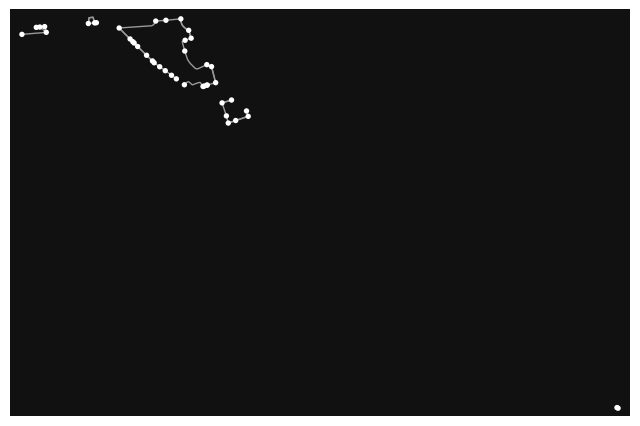

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [140]:
subgraph_of_closest_nodes = graph_of_area.subgraph(flattened_closest_nodes)
ox.plot_graph(subgraph_of_closest_nodes)

In [166]:
# subgraph_cleaned = cascade_delete_directed(G_sub.copy())

In [170]:
rerouted_graph = nx.compose(subgraph_of_closest_nodes, G_sub)

In [ ]:
import json
import random
import time
import dask.bag as db
import geopandas as gpd
import matplotlib.pyplot as plt
from dask import delayed, compute
from dask.distributed import Client
from tqdm import tqdm

In [478]:
def generate_supercommunity(communities):
    for i, community in enumerate(communities):
        yield i

def get_boundary_node_pair(community_pair, supercommunity, original_graph) -> tuple[tuple, int]:
    """Returns boundary nodes as a 2D NumPy array for two communities."""
    comm1, comm2 = community_pair
    if comm1 == comm2:
        return None
        
    comm1_nodes = np.array(list(supercommunity[comm1]), ndmin=1)
    comm2_nodes = np.array(list(supercommunity[comm2]), ndmin=1)
    path_lengths = []
    for i, pair in enumerate(itertools.product(comm1_nodes, comm2_nodes)):  # get cartesian product
        source, target = pair
        if nx.has_path(original_graph, source, target):
            path_lengths.append(((source, target), nx.shortest_path_length(original_graph, source, target)))
    results = sorted(path_lengths, key=lambda x: x[1], reverse=True)
    if len(results) == 0:
        return None
    else:
        return results[0]

In [352]:
sccs = [c for c in sorted(nx.strongly_connected_components(G_sub), key=len, reverse=True) if len(c) > 1]

In [353]:
super_community = list(generate_supercommunity(sccs))

In [ ]:
intermediate_community_pairs = list(itertools.product(super_community, super_community))

In [355]:
pair_distances = {}
for community_pair in intermediate_community_pairs:
    boundary_node_pair = get_boundary_node_pair(community_pair, sccs, G)
    if boundary_node_pair is not None:
        distance = boundary_node_pair[1]
        boundary_nodes = boundary_node_pair[0]
        pair = tuple(sorted(community_pair))
        if pair not in pair_distances:
            pair_distances[pair] = boundary_node_pair
        else:
            if pair_distances[pair][1] > distance:
                pair_distances[pair] = boundary_node_pair

NodeNotFound: Either source 364050310 or target 6527718242 is not in G

In [ ]:
pair_distances

In [356]:
intermediate_community_pairs = np.stack((super_community[:-1], super_community[1:]), axis=1)
intermediate_community_pairs

array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6],
       [6, 7],
       [7, 8]])

In [357]:
pair_distances = {}
for community_pair in intermediate_community_pairs:
    boundary_node_pair = get_boundary_node_pair(community_pair, sccs, G)
    if boundary_node_pair is not None:
        pair_distances[tuple(community_pair)] = boundary_node_pair

NodeNotFound: Either source 242925668 or target 6527718242 is not in G

In [316]:
pair_distances

{(0, 1): ((243193964, 25353435), 62)}

In [349]:
rerouted_graphs = []
for item in pair_distances.values():
    source, target = item[0]
    nx.shortest_path

KeyError: 0

In [ ]:
connecting_graphs = 

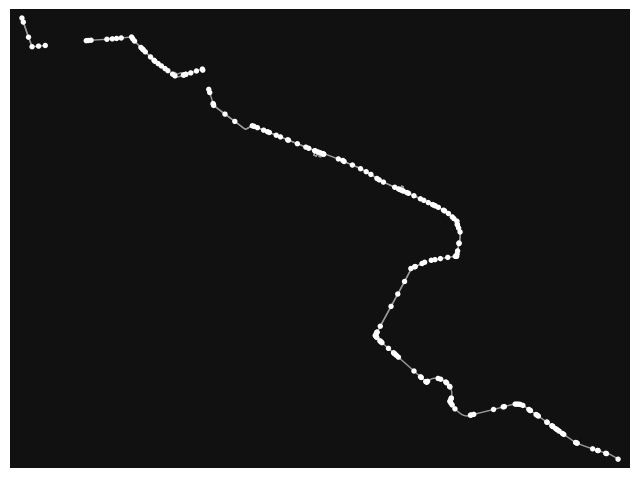

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [171]:
ox.plot_graph(G_sub)

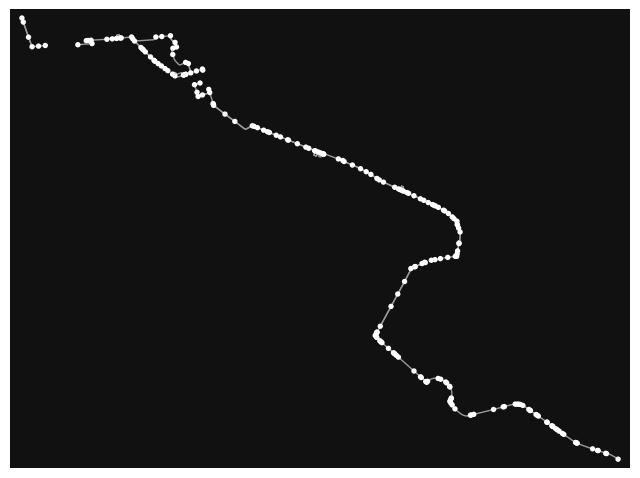

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [172]:
ox.plot_graph(rerouted_graph)

In [76]:
for node_id in deleted_nodes:
    G.remove_node(node_id)

In [80]:
shortest_path = nx.shortest_path(G, source=source, target=target, weight="length")  # Adjust weight as needed
print("Shortest path from source to target:", shortest_path)

NodeNotFound: Either source 26365570 or target 6698508125 is not in G

### Visualize the result

In [49]:
new_route = G.subgraph(shortest_path)

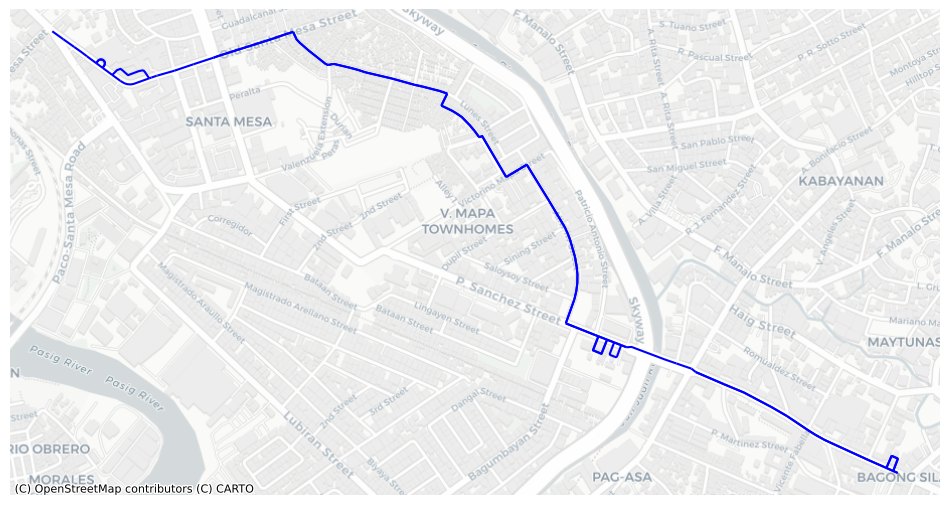

In [50]:
new_route_edges = ox.graph_to_gdfs(new_route, nodes=False)
_, ax = plt.subplots(figsize=(12, 12))
new_route_edges = new_route_edges.to_crs(epsg=3857)
new_route_edges.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

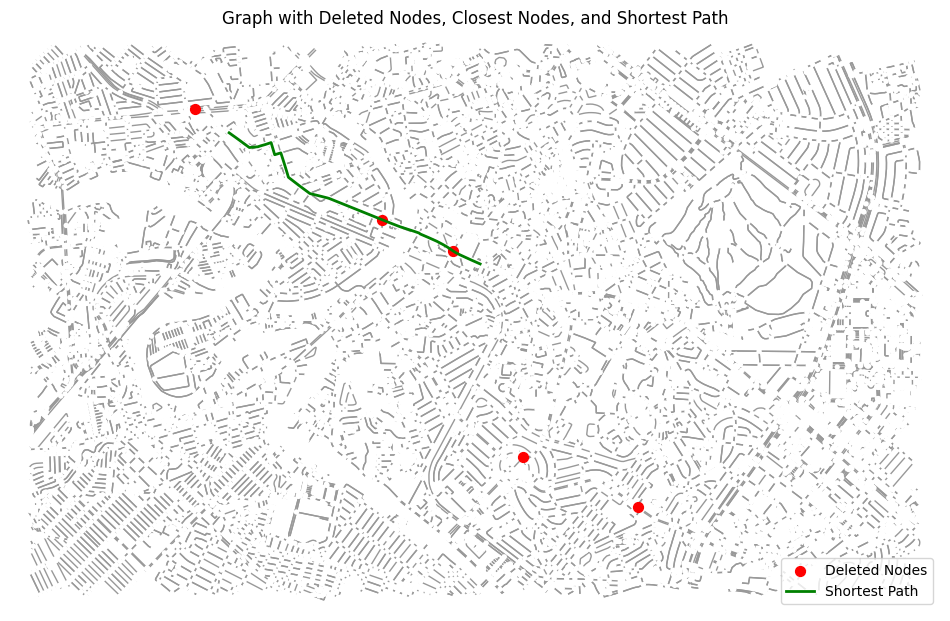

In [174]:
# Plotting the graph
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, ax=ax, show=False, close=False)

# Plot deleted nodes
deleted_node_x = [G.nodes[node]['x'] for node in deleted_nodes]
deleted_node_y = [G.nodes[node]['y'] for node in deleted_nodes]
ax.scatter(deleted_node_x, deleted_node_y, c='red', s=50, label='Deleted Nodes')

# Plot shortest path
path_x = [G.nodes[n]['x'] for n in shortest_path]
path_y = [G.nodes[n]['y'] for n in shortest_path]
ax.plot(path_x, path_y, c='green', linewidth=2, label='Shortest Path')

# Customize plot
plt.title("Graph with Deleted Nodes, Closest Nodes, and Shortest Path")
plt.legend()
plt.show()

### Plotting Route

In [65]:
# Create a GeoDataFrame for ways
gdf_way_points = gpd.GeoSeries(pd.Series(get_ways()), crs="EPSG:4326") # WGS84

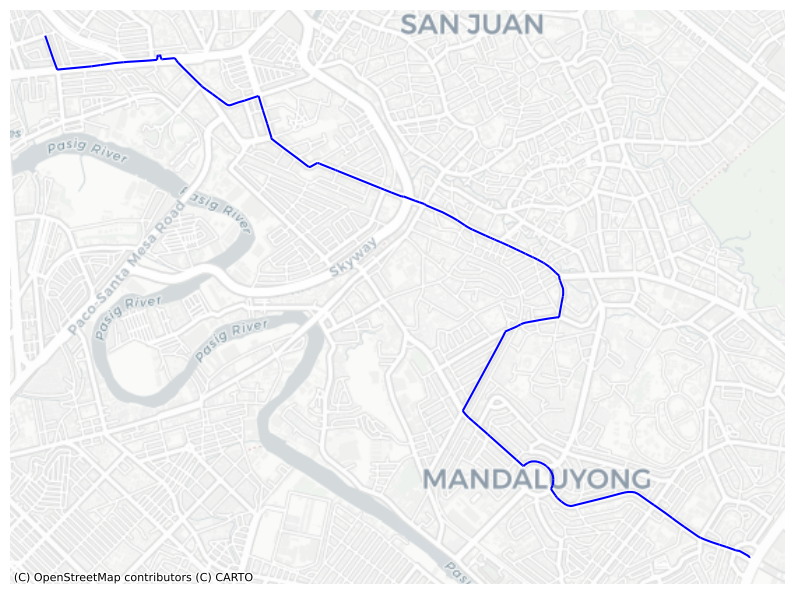

In [66]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_ways_wm = gdf_way_points.to_crs(epsg=3857)
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Plotting nodes.

In [67]:
# Create a GeoDataFrame for ways
gdf_node_points = gpd.GeoSeries(pd.Series(get_nodes()), crs="EPSG:4326")  # WGS84

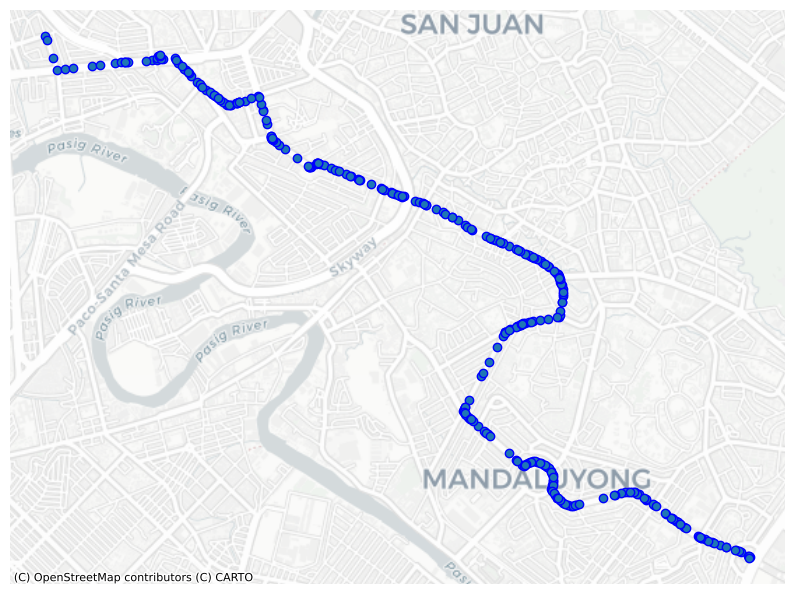

In [68]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm = gdf_node_points.to_crs(epsg=3857)
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Now, let's overlay the nodes and the ways together.

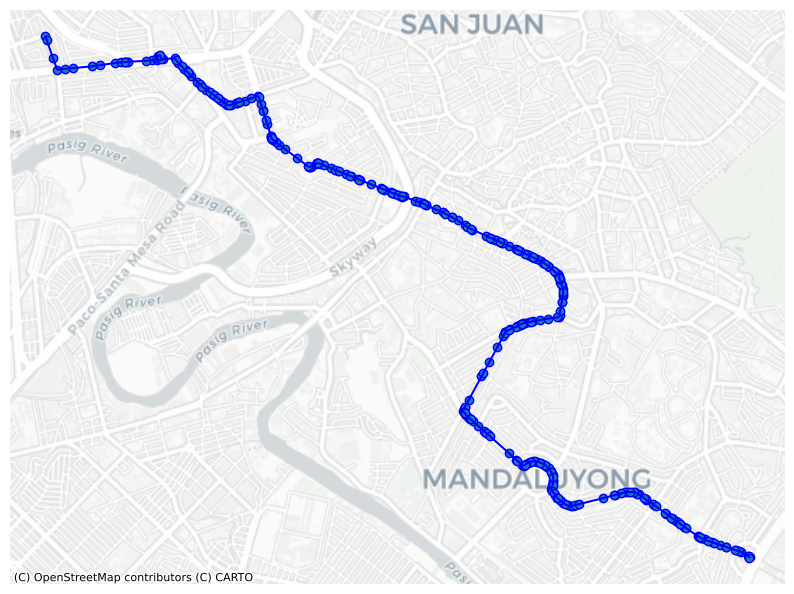

In [69]:
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()